# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

Using TensorFlow backend.


# Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255
x_test = x_test / 255

In [3]:
M,N,L = 32,32,3
IM_SHAPE = (M,N,L)
ENCODE_LEN = 64

In [4]:
IM_DIR = os.getcwd() + '/natural_images/dog/'
filetype = '.jpg'
files = os.listdir(IM_DIR)
NUM_IMS = 700
assert(len(files) > NUM_IMS)
images = np.zeros((NUM_IMS, ) + IM_SHAPE)
i = 0
for filename in files:
    if filename[-4:] == '.jpg':
        im = plt.imread(IM_DIR + filename)
        if len(im.shape) == 3:
            im = cv2.resize(im, IM_SHAPE[:2])
            im = im / 255
            images[i] = im
            i += 1
            if i >= NUM_IMS:
                break
images = np.array(images)
images.shape

(700, 32, 32, 3)

# Make Model

In [756]:
inputs = keras.Input(shape=IM_SHAPE)
inputsB = keras.Input(shape=IM_SHAPE)

grads = layers.Conv2D(filters=16,
                      kernel_size=2,
                      strides=2,
                      activation='tanh')(inputs)

grads = layers.Conv2D(filters=32,
                      kernel_size=2,
                      strides=2,
                      activation='tanh')(grads)

grads = layers.Conv2D(filters=128,
                      kernel_size=3,
                      strides=1,
                      activation='tanh')(grads)

grads = layers.Conv2D(filters=256,
                      kernel_size=3,
                      strides=1,
                      activation='tanh')(grads)

encoding = layers.Conv2D(filters=256,
                      kernel_size=3,
                      strides=1,
                      activation='tanh')(grads)

encoding = layers.Flatten()(encoding)

ENCODE = 64
encoding = layers.Dense(ENCODE, activation='sigmoid')(encoding)

encoder = keras.Model(inputs=inputs, outputs=encoding)
encoder.summary()

mix = layers.Dot(axes=1)([encoder(inputs), encoder(inputsB)]) / ENCODE

classifier= keras.Model(inputs=[inputs, inputsB], outputs=mix)
opt = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
classifier.compile(optimizer=opt, loss='mean_squared_error')
classifier.summary()

Model: "model_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_129 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 16, 16, 16)        208       
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 8, 8, 32)          2080      
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 6, 6, 128)         36992     
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 4, 4, 256)         295168    
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 2, 2, 256)         590080    
_________________________________________________________________
flatten_51 (Flatten)         (None, 1024)              0 

# Train

W0421 19:59:45.100641  1304 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


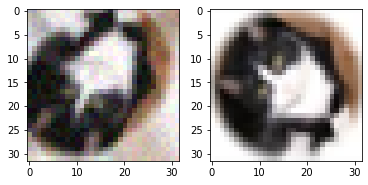

In [757]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=45,
    horizontal_flip=1,
    vertical_flip=1,
    channel_shift_range=0.1,
    shear_range=15,
)
datagen.fit(x_train)

for x, y in datagen.flow(x_test, x_test):
    x = x + (30/255)*np.random.rand(*x.shape)
    plt.subplot(1, 2, 1)
    plt.imshow(x[0])
    plt.subplot(1, 2, 2)
    plt.imshow(y[0])
    break

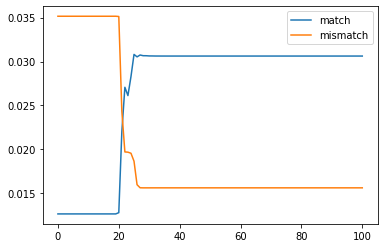

In [759]:
i = 0
match_loss = []
mismatch_loss = []
nitts = 100
for x,y in datagen.flow(x_train, x_train, batch_size=128):
    
#     x = x + (30/255)*np.random.rand(*x.shape)
#     y = y + (30/255)*np.random.rand(*x.shape)
    
    match_ans = .3 * np.ones((len(x),1))
    mismatch_ans = np.zeros((len(x)-1,1))
    
    match_history = classifier.fit([x, y], match_ans, epochs=1, verbose=0).history
    mismatch_history = classifier.fit([y[1:], y[:-1]],mismatch_ans, epochs=1, verbose=0).history
    match_loss.append(match_history['loss'][0])
    mismatch_loss.append(mismatch_history['loss'][0])
    
    classifier.fit([y, x], match_ans, epochs=1, verbose=0)
    classifier.fit([x[1:], x[:-1]],mismatch_ans, epochs=1, verbose=0)
    
#     classifier.fit([y, y],match_ans, epochs=1, verbose=0)
    classifier.fit([x[2:], x[:-2]],mismatch_ans[1:], epochs=1, verbose=0)

    print(f'{100*i / nitts:.1f}% ( {match_loss[-1]:.3f} , {mismatch_loss[-1]:.3f} )', end='\r')
    
    i += 1
    if i > nitts:
        break
plt.plot(match_loss)
plt.plot(mismatch_loss)
plt.legend(['match','mismatch'])

In [745]:
def similarity(im1, im2, plot=True):
    vecs = encoder.predict(np.array([im1, im2]))
#     sim = np.dot(vecs[0],vecs[1]) / 512
    sim = cosSim(vecs[0], vecs[1])
    if plot:
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(im1)
        plt.subplot(1,2,2)
        plt.imshow(im2)
        plt.title(sim)
    return sim

def Esim(im1, im2):
    return classifier.predict([np.array([im1]), np.array([im2])])[0,0]

def cosSim(x,y):
    return np.dot(x,y) / (np.linalg.norm(x) * np.linalg.norm(y))

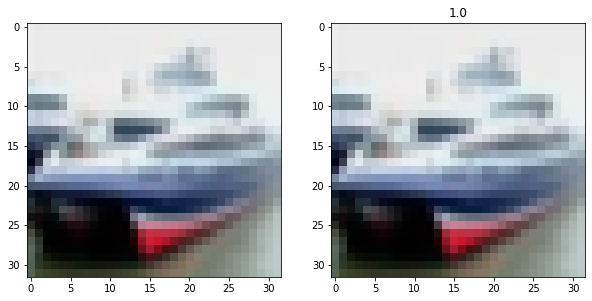

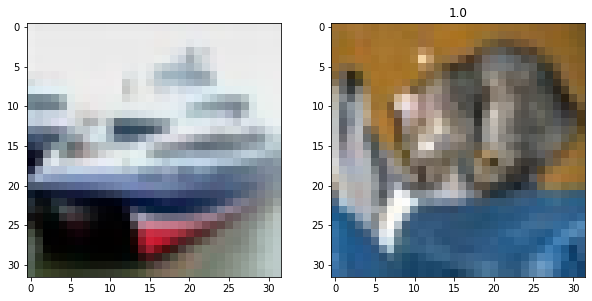

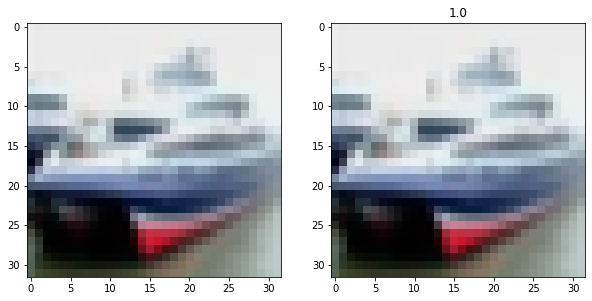

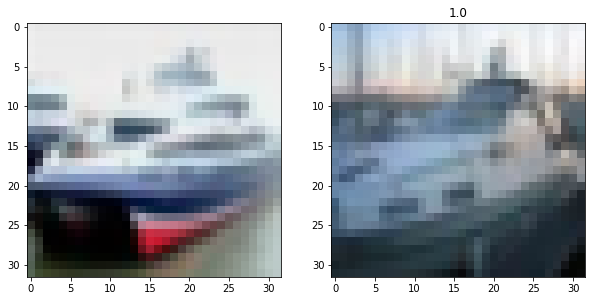

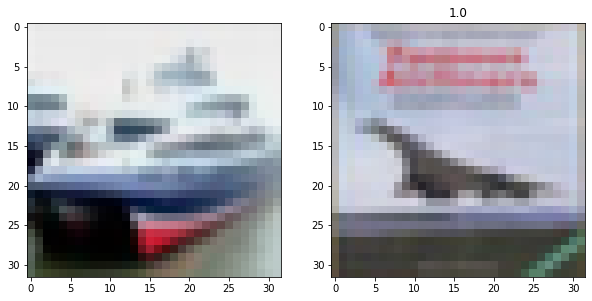

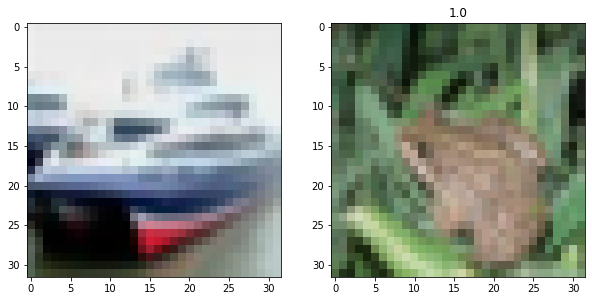

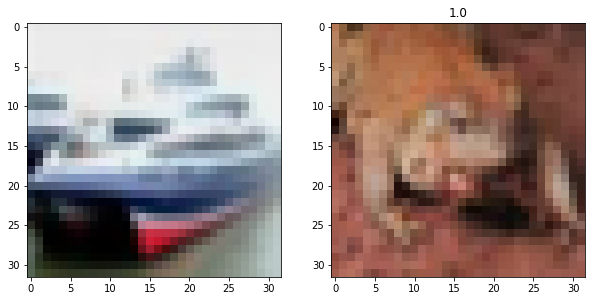

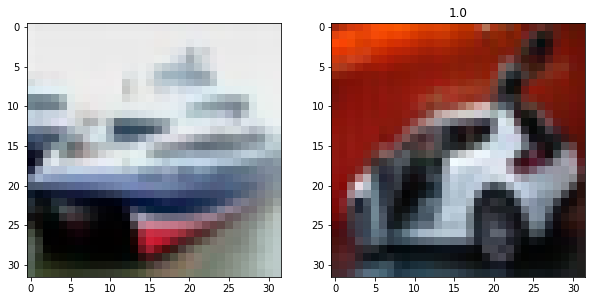

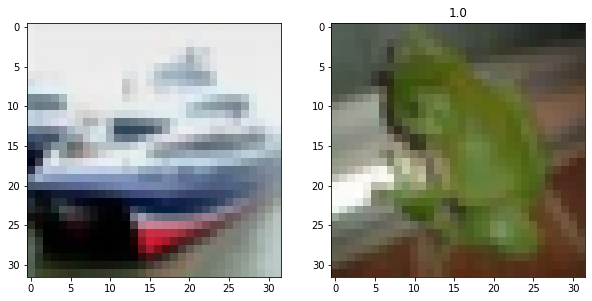

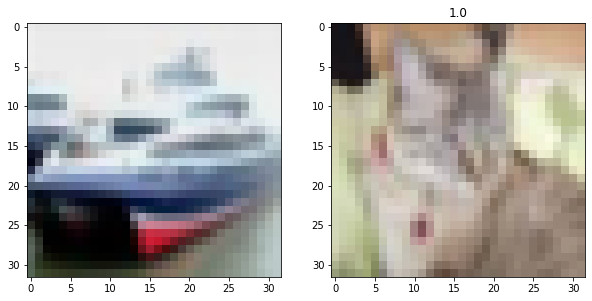

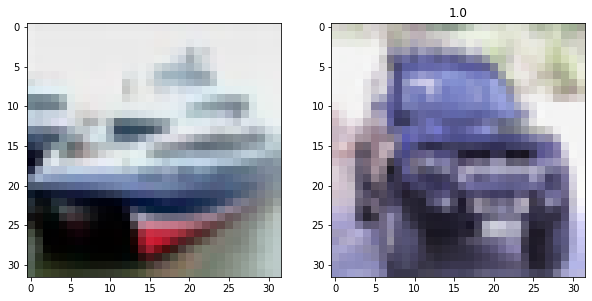

In [760]:
j = np.random.randint(1000)
j = 1
similarity(x_test[j], x_test[j])
for i in range(10):
    similarity(x_test[j], x_test[i])

In [747]:
encodings = encoder.predict(x_test)
n= len(x_test)
n = 1000
affinity = np.zeros((n,n))
for i in range(n):
    print(f'{100*i/n:.3f}%', end='\r')
    for j in range(i,n):
        affinity[i,j] = cosSim(encodings[i], encodings[j])
        affinity[j,i] = affinity[i,j]

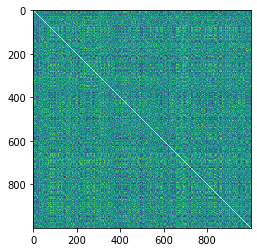

In [748]:
plt.imshow(affinity)

In [749]:
aProp = AffinityPropagation(affinity='precomputed')
aff_clusters = aProp.fit_predict(affinity)

c:\users\royce schultz\appdata\local\programs\python\python37\lib\site-packages\sklearn\cluster\_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


In [750]:
adjusted_rand_score(y_test[:n].reshape((-1,)), aff_clusters)

0.0

11


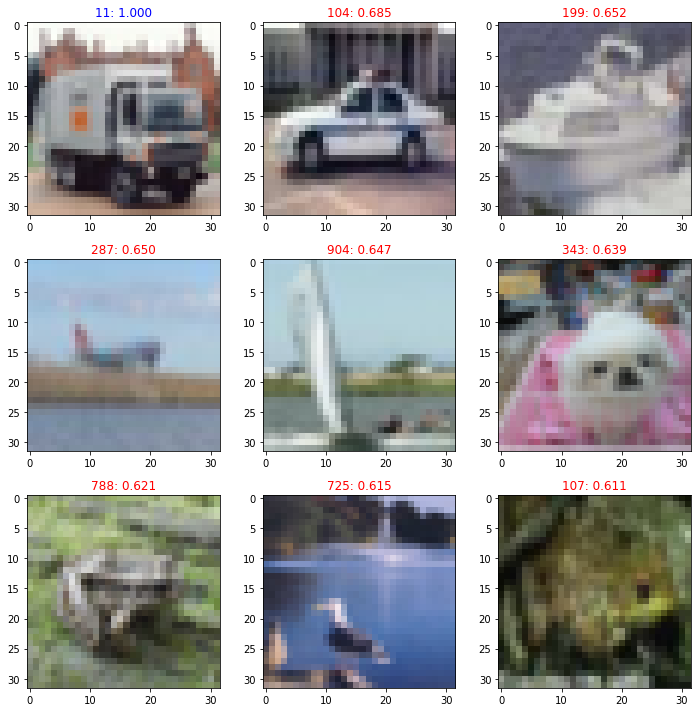

In [751]:
row = 11
print(row)
ranks = np.argsort(affinity[row,:])[::-1]
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[ranks[i]])
    if y_test[ranks[i]] == y_test[row]:
        fd = {'color':'b'}
    else:
        fd = {'color':'r'}
    plt.title(f'{ranks[i]}: {affinity[row,ranks[i]]:.3f}', fontdict=fd)
plt.tight_layout()

In [670]:
def testClusters(clusters):
    return adjusted_rand_score(y_test.reshape((-1,)), clusters)

def testEncodings(encodings):
    print('calculating k means...')
    k_clusters = KMeans(10).fit_predict(encodings)
    print('calculating agglomerative clustering...')
    a_clusters = AgglomerativeClustering(10).fit_predict(encodings)
    print(f'K Means Score: {testClusters(k_clusters)}')
    print(f'Agglomerative Score: {testClusters(a_clusters)}')

In [752]:
encodings = encoder.predict(x_test)

In [753]:
testEncodings(encodings)

calculating k means...
calculating agglomerative clustering...
K Means Score: 0.01739517545816595
Agglomerative Score: 0.009802952890508903


In [ ]:
testEncodings(x_shrink)

In [ ]:
testEncodings(np.random.rand(len(x_shrink),1))

In [ ]:
def testAccuracy(acc):
    n = 10000
    true_labels = np.random.randint(10, size=(n,))
    pred_labels = np.zeros(n)
    for i in range(n):
        if np.random.rand() >= acc:
            pred_labels[i] = np.random.randint(10)
            while pred_labels[i] == true_labels[i]:
                pred_labels[i] = np.random.randint(10)
        else:
            pred_labels[i] = true_labels[i]
            
    return adjusted_rand_score(true_labels, pred_labels)


In [ ]:
testAccuracy(.80)

In [ ]:
xs = np.linspace(0,1,100)
ys = np.zeros(100)
for i,x in enumerate(xs):
    ys[i] = testAccuracy(x)
plt.plot(xs,ys)

In [ ]:
start=5
end=20
plt.plot(xs[start:end],ys[start:end])